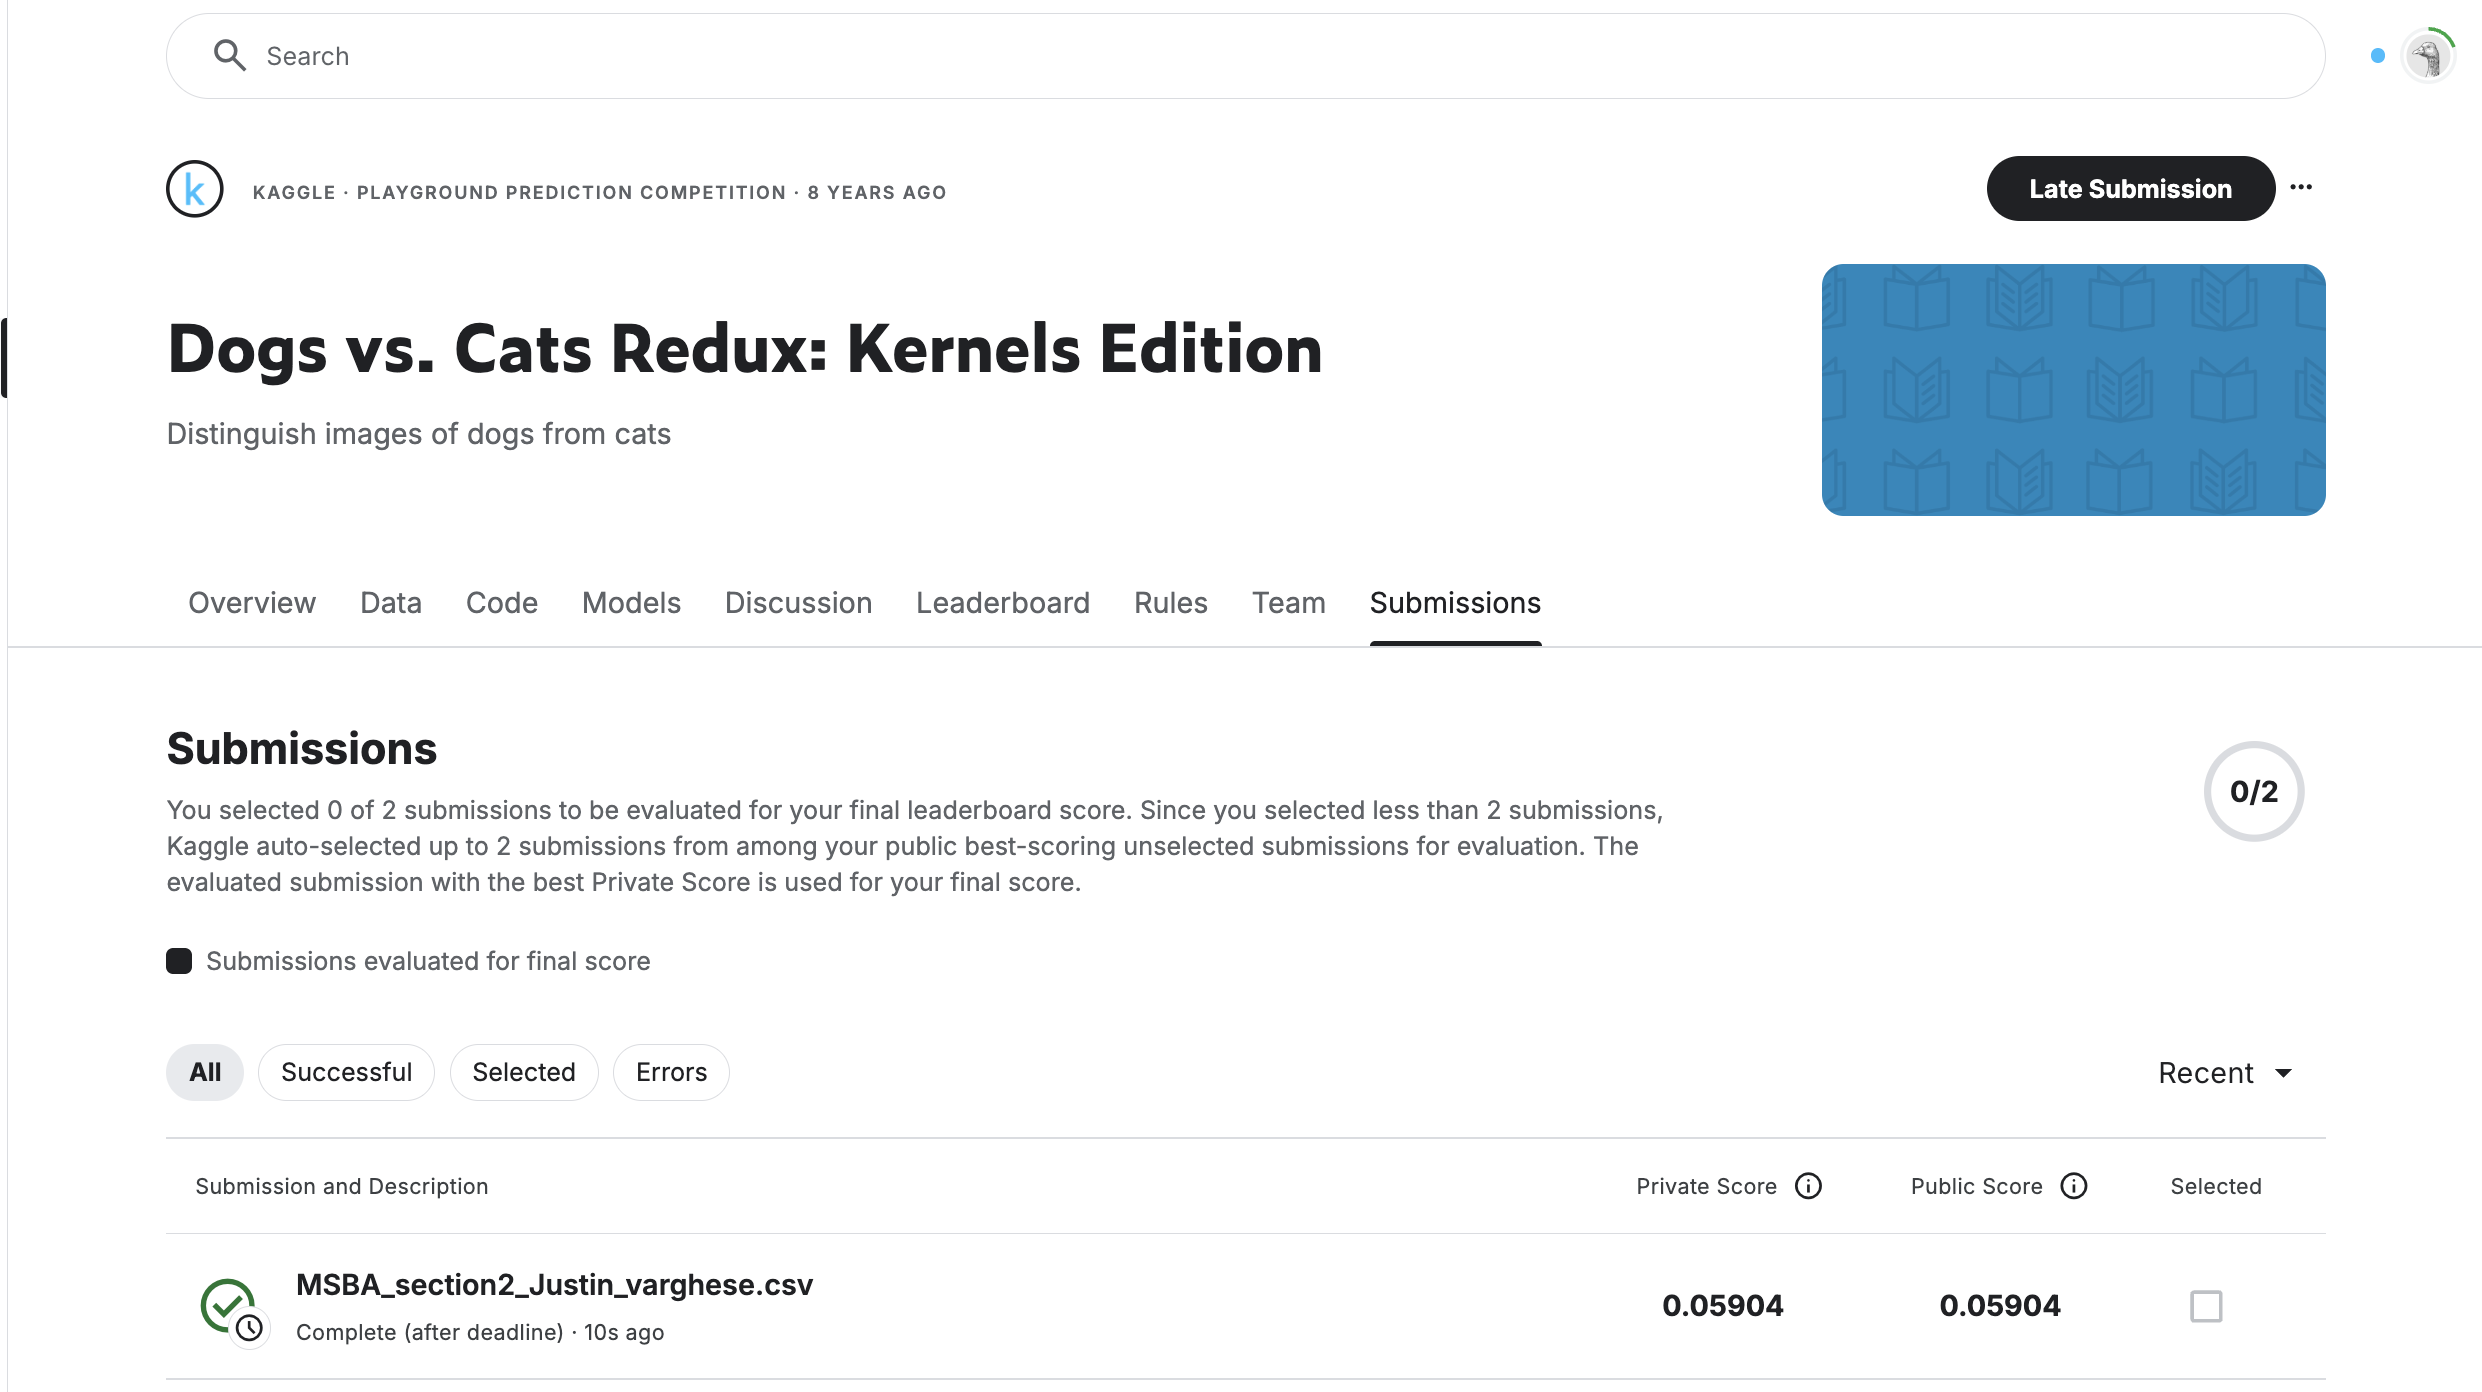


# Cats vs. Dogs Redux - MSBA Image Classification Submission

Welcome to my submission for the Cats vs. Dogs Redux classification task.

The goal is to build a classifier that can distinguish between images of cats and dogs using machine learning and deep learning techniques. The final model is evaluated using **log loss**, and the output must be a probability between 0 and 1 that each image in the test set is a dog.

In this notebook, I walk through three levels of modeling:
A baseline CNN built with Keras (to establish a performance floor)
Classical Neural Network using pretrained image embeddings


The final model submission is based on the best performing approach from the above.

## Step 1: Unpack & Explore the Dataset

We begin by extracting the image files from the provided zip archives and visualizing some sample images. Each image file in the training set is named in the format `cat.123.jpg` or `dog.456.jpg`, which makes it easy to extract the label.

We also inspect the class distribution to confirm that the dataset is balanced.

✅ Train and test images extracted.
✅ Total training images: 25000
✅ Total test images: 12500


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


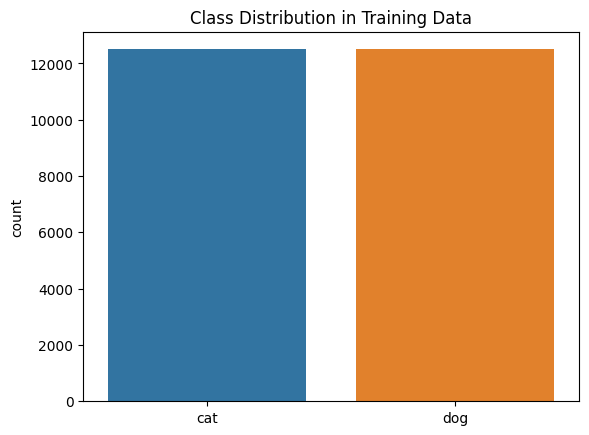

In [ ]:
import os, zipfile, glob, random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Constants
BASE_DIR = '/kaggle/input/dogs-vs-cats-redux-kernels-edition'
DATA_DIR = '/kaggle/working/data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Create folders
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# Extract train.zip and test.zip into respective folders
with zipfile.ZipFile(os.path.join(BASE_DIR, 'train.zip')) as zip_obj:
    zip_obj.extractall(TRAIN_DIR)

with zipfile.ZipFile(os.path.join(BASE_DIR, 'test.zip')) as zip_obj:
    zip_obj.extractall(TEST_DIR)

print("✅ Train and test images extracted.")

# -------------------------------------------
# Fix: Your images are in /train/train/ and /test/test/
train_list = sorted(glob.glob(os.path.join(TRAIN_DIR, '**', '*.jpg'), recursive=True))
test_list = sorted(glob.glob(os.path.join(TEST_DIR, '**', '*.jpg'), recursive=True))

print(f"✅ Total training images: {len(train_list)}")
print(f"✅ Total test images: {len(test_list)}")

# Plot class distribution
labels = ['dog' if 'dog' in os.path.basename(path) else 'cat' for path in train_list]
sns.countplot(x=labels)
plt.title("Class Distribution in Training Data")
plt.show()

# Show 10 random training images
sample_imgs = random.sample(train_list, 10)
plt.figure(figsize=(15, 5))
for i, img_path in enumerate(sample_imgs):
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path))
    plt.axis('off')
plt.suptitle("Sample Images from Training Set", fontsize=14)
plt.tight_layout()
plt.show()

Data is properly loading , and the classes are balanced

## Step 2: Baseline CNN with TensorFlow/Keras

To establish a baseline, we train a simple Convolutional Neural Network using Keras.

We also apply data augmentation techniques like horizontal flipping and zoom to improve generalization. This model should give us a benchmark accuracy and loss score to compare more complex models against.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
import os

# Image parameters
IMG_SIZE = 150
BATCH_SIZE = 32

# ✅ Fix: Correct subdirectory
CORRECT_TRAIN_PATH = os.path.join(TRAIN_DIR, 'train')  # e.g. '/kaggle/working/data/train/train'

# Create dataframe of labels from filenames
df = pd.DataFrame({'filename': [os.path.basename(p) for p in train_list]})
df['label'] = df['filename'].apply(lambda x: 'dog' if 'dog' in x else 'cat')

# Train/validation split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Image generators with augmentation
train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
val_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_dataframe(train_df,
                                           directory=CORRECT_TRAIN_PATH,
                                           x_col='filename',
                                           y_col='label',
                                           target_size=(IMG_SIZE, IMG_SIZE),
                                           class_mode='binary',
                                           batch_size=BATCH_SIZE)

val_data = val_gen.flow_from_dataframe(val_df,
                                       directory=CORRECT_TRAIN_PATH,
                                       x_col='filename',
                                       y_col='label',
                                       target_size=(IMG_SIZE, IMG_SIZE),
                                       class_mode='binary',
                                       batch_size=BATCH_SIZE)

# Define a simple CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=5)

2025-04-22 04:15:14.512856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745295314.760270      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745295314.861387      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745295329.084073      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745295329.084834      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745295334.218274      79 service.cc:148] XLA service 0x79767800ba10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745295334.219675      79 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745295334.219697      79 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745295334.520526      79 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/625 ━━━━━━━━━━━━━━━━━━━━ 1:13:43 7s/step - accuracy: 0.5312 - loss: 0.6957

I0000 00:00:1745295337.891489      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 121s 183ms/step - accuracy: 0.5877 - loss: 0.7121 - val_accuracy: 0.7082 - val_loss: 0.5765
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 180ms/step - accuracy: 0.7059 - loss: 0.5689 - val_accuracy: 0.7574 - val_loss: 0.5114
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 180ms/step - accuracy: 0.7477 - loss: 0.5121 - val_accuracy: 0.7850 - val_loss: 0.4650
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 179ms/step - accuracy: 0.7784 - loss: 0.4686 - val_accuracy: 0.7994 - val_loss: 0.4258
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 179ms/step - accuracy: 0.7880 - loss: 0.4507 - val_accuracy: 0.8030 - val_loss: 0.4360


Now we got a bench mark so we try to make a better model than this and compare it to this simple cnn

## Step 3: Pre tained Embeddings

Here we use pretrained EfficientNet embeddingsand save it as .npy files for training effeciency 


We will use these embeddings to train the neural network model

In [3]:
%pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00:00:0100:01
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=8e3224ad88f84f6890697bd8b260d29aba73675f35265911f5e6cdfc159a3726
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_py

In [4]:
import os
import numpy as np
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import torch

# Load EfficientNet-B7 pretrained model
model = EfficientNet.from_pretrained('efficientnet-b7')
model.eval()
model.cuda()

# Image transform (resize + normalize for EfficientNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Feature extraction function
def extract_features(img_paths):
    features = []
    with torch.no_grad():
        for path in tqdm(img_paths):
            img = Image.open(path).convert("RGB")
            x = transform(img).unsqueeze(0).cuda()
            feat = model.extract_features(x).mean([2, 3])  # Global average pooling
            features.append(feat.cpu().numpy().flatten())
    return np.array(features)

# ✅ Correct image paths
TRAIN_IMG_DIR = '/kaggle/working/data/train/train'  
TEST_IMG_DIR = '/kaggle/working/data/test/test'    

train_paths = sorted(glob.glob(os.path.join(TRAIN_IMG_DIR, '*.jpg')))
def numeric_key(path):
    return int(os.path.splitext(os.path.basename(path))[0])

test_paths = sorted(glob.glob(os.path.join(TEST_IMG_DIR, '*.jpg')), key=numeric_key)

print(f"Train images found: {len(train_paths)}")
print(f"Test images found: {len(test_paths)}")

# Run extraction
train_features = extract_features(train_paths)
test_features = extract_features(test_paths)

# Save embeddings
np.save('/kaggle/working/train_EB7_ns.npy', train_features)
np.save('/kaggle/working/test_EB7_ns.npy', test_features)

# Generate and save binary labels
target = np.array([1 if 'dog' in os.path.basename(f) else 0 for f in train_paths])
np.save('/kaggle/working/target.npy', target)

print("✅ Features + labels saved to /kaggle/working/")

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth
100%|██████████| 254M/254M [00:01<00:00, 222MB/s] 


Loaded pretrained weights for efficientnet-b7
Train images found: 25000
Test images found: 12500


100%|██████████| 12500/12500 [09:08<00:00, 22.79it/s]


✅ Features + labels saved to /kaggle/working/


In [5]:
import numpy as np
print(np.load("/kaggle/working/train_EB7_ns.npy").shape)
print(np.load("/kaggle/working/target.npy").shape)
print(np.load("/kaggle/working/test_EB7_ns.npy").shape)

(25000, 2560)
(25000,)
(12500, 2560)


In [ ]:
pip install scikit-learn

## Step 4: Hyper parameter tuning

Here we use Bayesean Optimisation to get the best hyperparameter for the neural network
here we are using an 5 later neural network and swish activation function as the input values have negative. I included l2 regularisation because i felt it was overfitting as i was getting lower loss on the training dataset and higher loss on the testing. 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import optuna
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import swish
from tensorflow.keras.activations import gelu

# Load data
X = np.load("/kaggle/working/train_EB7_ns.npy")
y = np.load("/kaggle/working/target.npy")

# Define model builder
def build_model(n_units1, n_units2, n_units3, dropout_rate, learning_rate, input_dim,l2_strength):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(n_units1, activation=gelu, kernel_regularizer=l2(l2_strength)),
        Dropout(dropout_rate),
        Dense(n_units2, activation=gelu, kernel_regularizer=l2(l2_strength)),
        Dropout(dropout_rate),
        Dense(n_units3, activation=gelu, kernel_regularizer=l2(l2_strength)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])  # You can remove 'accuracy' if you're only tracking log loss
    return model

# Objective function for Optuna
def objective(trial):
    n_units1 = trial.suggest_categorical('n_units1', [128,256,512])
    n_units2 = trial.suggest_categorical('n_units2', [128,256,512])
    n_units3 = trial.suggest_categorical('n_units3', [64,128,256])
    dropout_rate = trial.suggest_float('dropout', 0.3, 0.5)    
    learning_rate = trial.suggest_float('lr', 5e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])   
    epochs = trial.suggest_int('epochs', 10, 30)
    l2_strength = trial.suggest_float("l2", 1e-5, 1e-3, log=True)

    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    log_losses = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = build_model(n_units1,n_units2,n_units3, dropout_rate, learning_rate, X.shape[1],l2_strength)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                  verbose=0, validation_data=(X_val, y_val))

        val_preds = model.predict(X_val, verbose=0).flatten()
        log_losses.append(log_loss(y_val, val_preds))

    avg_log_loss = np.mean(log_losses)
    print(f"Trial Loss = {avg_log_loss:.5f} → {trial.params}")
    return avg_log_loss

# Run Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("\n✅ Best Trial:")
print(study.best_trial)

## Step 4: Final Model and deployment

Here we train the final neural network model on the final hyper paramters and deploy it to get the final predictions

In [ ]:
import numpy as np
import pandas as pd
import glob
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import swish

# Load data
X = np.load("/kaggle/working/train_EB7_ns.npy")
X_test = np.load("/kaggle/working/test_EB7_ns.npy")
y = np.load("/kaggle/working/target.npy")

# ✅ Best parameters from Optuna
params = {
    'n_units1': 128,
    'n_units2': 128,
    'n_units3': 64,
    'dropout': 0.30503416830870733,
    'lr': 1.6254339782398033e-05,
    'batch_size': 32,
    'epochs': 10,
    'l2': 2.4159014618484995e-05
}

# Build the final model with Swish activation + L2
def build_final_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(params['n_units1'], activation=swish, kernel_regularizer=l2(params['l2'])),
        Dropout(params['dropout']),
        Dense(params['n_units2'], activation=swish, kernel_regularizer=l2(params['l2'])),
        Dropout(params['dropout']),
        Dense(params['n_units3'], activation=swish, kernel_regularizer=l2(params['l2'])),
        Dense(1, activation='sigmoid')  # Output = probability of being a dog
    ])
    model.compile(optimizer=Adam(learning_rate=params['lr']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# ✅ Train final model on all data
final_model = build_final_model(X.shape[1])
final_model.fit(X, y, batch_size=params['batch_size'], epochs=params['epochs'], verbose=1)

# ✅ Predict on test data
test_preds = final_model.predict(X_test).flatten()

# ✅ Load test image IDs (ensure matching order)
test_dir = '/kaggle/working/data/test/test'
test_paths = sorted(glob.glob(os.path.join(test_dir, '*.jpg')),
                    key=lambda x: int(os.path.basename(x).split('.')[0]))
test_ids = [int(os.path.basename(p).split('.')[0]) for p in test_paths]

# ✅ Build submission
submission_df = pd.DataFrame({
    "id": test_ids,
    "label": test_preds  # confidence score for being a dog
})
submission_df.to_csv("submission.csv", index=False)
print("✅ Final submission.csv saved with Swish + L2 regularization!")

In [ ]:
from IPython.display import FileLink
FileLink('submission.csv')

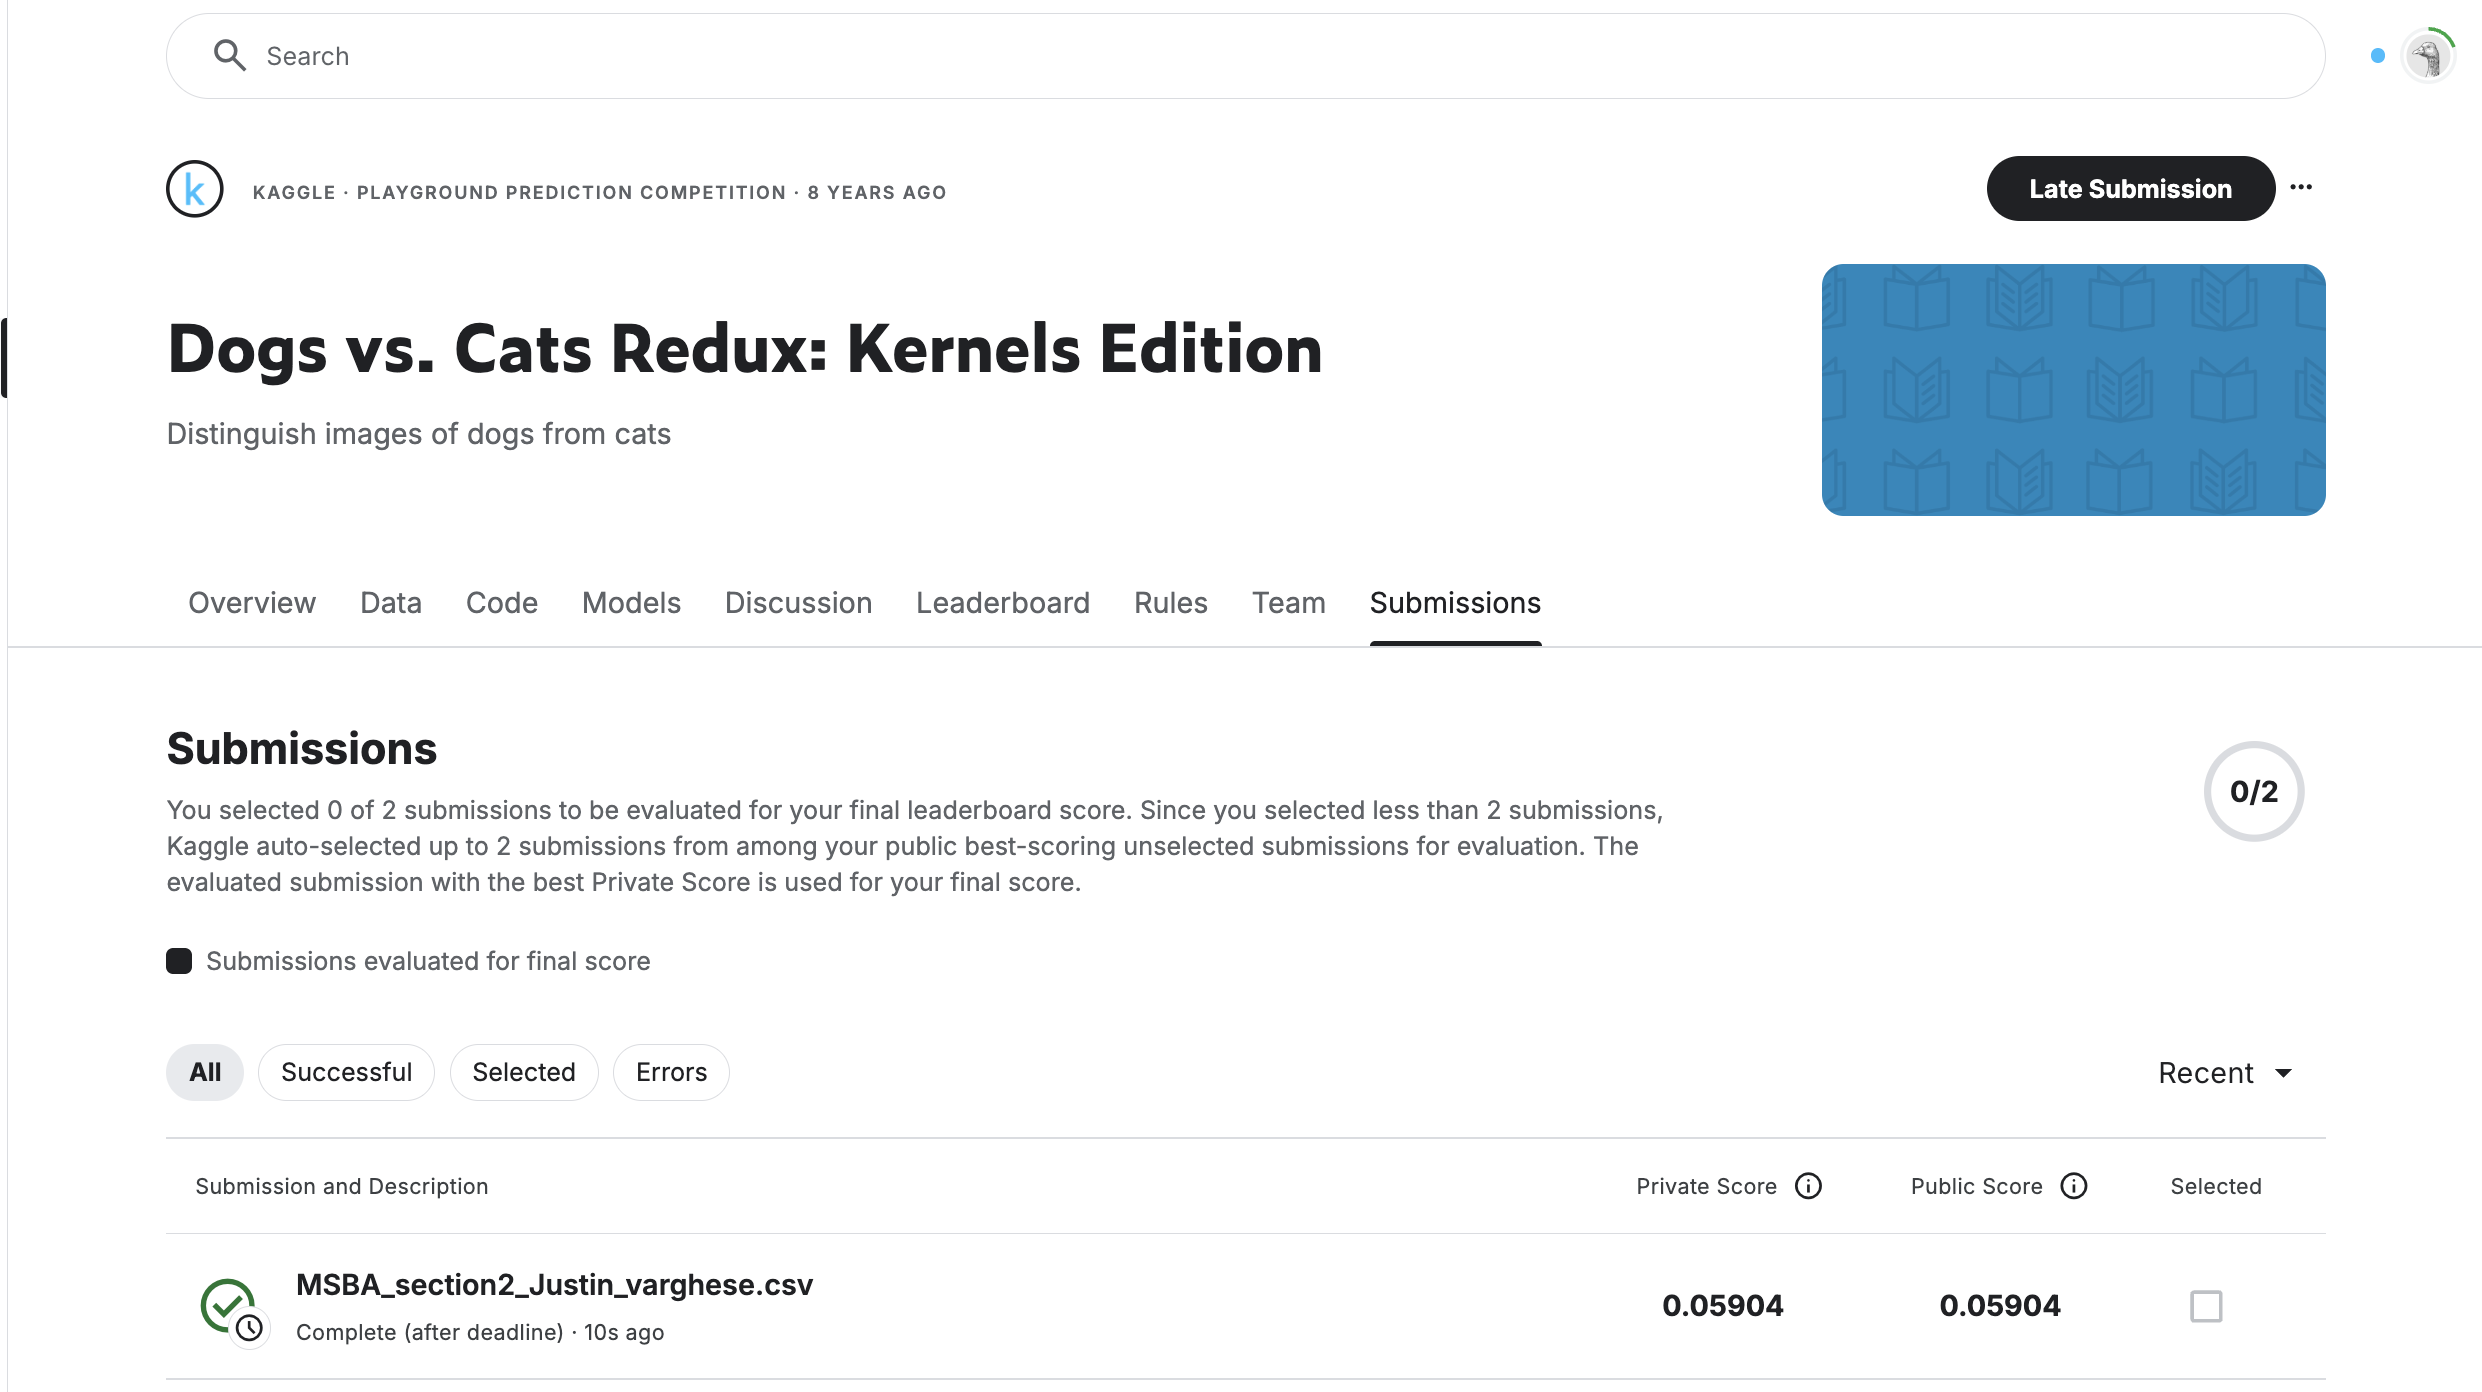